In [1]:
!kaggle datasets download -d agungpambudi/network-malware-detection-connection-analysis

Dataset URL: https://www.kaggle.com/datasets/agungpambudi/network-malware-detection-connection-analysis
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 715M/720M [00:09<00:00, 104MB/s] 
100% 720M/720M [00:09<00:00, 83.2MB/s]


In [2]:
!unzip ./network-malware-detection-connection-analysis.zip

Archive:  ./network-malware-detection-connection-analysis.zip
  inflating: CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv  
  inflating: CTU-IoT-Malware-Capture-20-1conn.log.labeled.csv  
  inflating: CTU-IoT-Malware-Capture-21-1conn.log.labeled.csv  
  inflating: CTU-IoT-Malware-Capture-3-1conn.log.labeled.csv  
  inflating: CTU-IoT-Malware-Capture-34-1conn.log.labeled.csv  
  inflating: CTU-IoT-Malware-Capture-35-1conn.log.labeled.csv  
  inflating: CTU-IoT-Malware-Capture-42-1conn.log.labeled.csv  
  inflating: CTU-IoT-Malware-Capture-44-1conn.log.labeled.csv  
  inflating: CTU-IoT-Malware-Capture-48-1conn.log.labeled.csv  
  inflating: CTU-IoT-Malware-Capture-60-1conn.log.labeled.csv  
  inflating: CTU-IoT-Malware-Capture-8-1conn.log.labeled.csv  
  inflating: CTU-IoT-Malware-Capture-9-1conn.log.labeled.csv  


In [3]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [4]:
df = pd.read_csv("./CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv", sep="|")

In [5]:
df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed-label
0,1.525880e+09,CUmrqr4svHuSXJy5z7,192.168.100.103,51524.0,65.127.233.163,23.0,tcp,-,2.999051,0,...,-,0.0,S,3.0,180.0,0.0,0.0,-,Malicious,PartOfAHorizontalPortScan
1,1.525880e+09,CH98aB3s1kJeq6SFOc,192.168.100.103,56305.0,63.150.16.171,23.0,tcp,-,-,-,...,-,0.0,S,1.0,60.0,0.0,0.0,-,Malicious,PartOfAHorizontalPortScan
2,1.525880e+09,C3GBTkINvXNjVGtN5,192.168.100.103,41101.0,111.40.23.49,23.0,tcp,-,-,-,...,-,0.0,S,1.0,60.0,0.0,0.0,-,Malicious,PartOfAHorizontalPortScan
3,1.525880e+09,CDe43c1PtgynajGI6,192.168.100.103,60905.0,131.174.215.147,23.0,tcp,-,2.998796,0,...,-,0.0,S,3.0,180.0,0.0,0.0,-,Malicious,PartOfAHorizontalPortScan
4,1.525880e+09,CJaDcG3MZzvf1YVYI4,192.168.100.103,44301.0,91.42.47.63,23.0,tcp,-,-,-,...,-,0.0,S,1.0,60.0,0.0,0.0,-,Malicious,PartOfAHorizontalPortScan


In [6]:
df.dtypes

,0
ts,float64
uid,object
id.orig_h,object
id.orig_p,float64
id.resp_h,object
id.resp_p,float64
proto,object
service,object
duration,object
orig_bytes,object


In [7]:
df['label_target'] = df['label'].apply(lambda x: 1 if x == 'Malicious' else 0)

In [8]:
df['duration'] = pd.to_numeric(df['duration'].str.replace('-','-1'))
df['orig_bytes'] = pd.to_numeric(df['orig_bytes'], errors='coerce')
df['resp_bytes'] = pd.to_numeric(df['resp_bytes'], errors='coerce')
df['orig_pkts'] = pd.to_numeric(df['orig_pkts'])
df['orig_ip_bytes'] = pd.to_numeric(df['orig_ip_bytes'])
df['resp_pkts'] = pd.to_numeric(df['resp_pkts'])
df['resp_ip_bytes'] = pd.to_numeric(df['resp_ip_bytes'])
df['ts'] = pd.to_datetime(df['ts'], unit='s')

df = pd.concat([df, pd.get_dummies(df['proto'])], axis=1)
df['icmp'] = pd.to_numeric(df['icmp'])
df['tcp'] = pd.to_numeric(df['tcp'])
df['udp'] = pd.to_numeric(df['udp'])

In [9]:
params = ['duration','orig_bytes','resp_bytes', 'orig_pkts', 'orig_ip_bytes','resp_pkts','resp_ip_bytes','icmp','tcp','udp']
label = 'label_target'

In [10]:
df['label'].value_counts()

,count
label,
Malicious,539473
Benign,469275


In [38]:
X = df[params]
y = df[label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [12]:
X.dtypes

,0
duration,float64
orig_bytes,float64
resp_bytes,float64
orig_pkts,float64
orig_ip_bytes,float64
resp_pkts,float64
resp_ip_bytes,float64
icmp,bool
tcp,bool
udp,bool


In [13]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, recall_score, f1_score, roc_auc_score

param_grid = {
    'num_leaves': [20, 31, 40],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500, 1000],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
}


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [14]:
# lgb_model = lgb.LGBMClassifier()
# random_search = RandomizedSearchCV(
#     estimator=lgb_model,
#     param_distributions=param_grid,
#     n_iter=50,
#     cv=3,
#     scoring='accuracy',
#     random_state=42,
#     verbose=1,
#     n_jobs=-1

# )
# random_search.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

# best_params = random_search.best_params_

best_params = dict(olsample_bytree=0.8, learning_rate=0.05, max_depth=30, n_estimators=200, num_leaves=40, subsample=0.9)
best_model = lgb.LGBMClassifier(**best_params)
best_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

[LightGBM] [Warning] Unknown parameter: olsample_bytree
[LightGBM] [Warning] Unknown parameter: olsample_bytree
[LightGBM] [Info] Number of positive: 377670, number of negative: 328453
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.277262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 706123, number of used features: 10
[LightGBM] [Warning] Unknown parameter: olsample_bytree
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.534850 -> initscore=0.139627
[LightGBM] [Info] Start training from score 0.139627


LGBMClassifier(learning_rate=0.05, max_depth=30, n_estimators=200,
               num_leaves=40, olsample_bytree=0.8, subsample=0.9)

In [15]:
y_pred = best_model.predict(X_test)
print("Accuracy:", round(100 * accuracy_score(y_test, y_pred),2))
print("Recall:",  round(100 * recall_score(y_test, y_pred),2))
print("Roc Auc:",  round(100 * roc_auc_score(y_test, y_pred),2))
print("F1 score:",  round(100 * f1_score(y_test, y_pred),2))
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Unknown parameter: olsample_bytree
Accuracy: 95.71
Recall: 100.0
Roc Auc: 95.38
F1 score: 96.14
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     70383
           1       0.93      1.00      0.96     80930

    accuracy                           0.96    151313
   macro avg       0.96      0.95      0.96    151313
weighted avg       0.96      0.96      0.96    151313



In [16]:
test_df = pd.read_csv("./CTU-IoT-Malware-Capture-34-1conn.log.labeled.csv", sep="|")

In [17]:
test_df['label'].value_counts()

,count
label,
Malicious DDoS,14394
Malicious C&C,6706
Benign,1923
Malicious PartOfAHorizontalPortScan,122


In [18]:
test_df['label_target'] = test_df['label'].apply(lambda x: 0 if x == 'Benign' else 1)

In [19]:
test_df['label_target'].value_counts()

,count
label_target,
1,21222
0,1923


In [20]:
test_df['duration'] = pd.to_numeric(test_df['duration'].str.replace('-','-1'))
test_df['orig_bytes'] = pd.to_numeric(test_df['orig_bytes'], errors='coerce')
test_df['resp_bytes'] = pd.to_numeric(test_df['resp_bytes'], errors='coerce')
test_df['orig_pkts'] = pd.to_numeric(test_df['orig_pkts'])
test_df['orig_ip_bytes'] = pd.to_numeric(test_df['orig_ip_bytes'])
test_df['resp_pkts'] = pd.to_numeric(test_df['resp_pkts'])
test_df['resp_ip_bytes'] = pd.to_numeric(test_df['resp_ip_bytes'])
test_df['ts'] = pd.to_datetime(test_df['ts'], unit='s')

test_df = pd.concat([test_df, pd.get_dummies(test_df['proto'])], axis=1)
test_df['icmp'] = 0
test_df['tcp'] = pd.to_numeric(test_df['tcp'])
test_df['udp'] = pd.to_numeric(test_df['udp'])

In [21]:
X_test = test_df[params]
y_test = test_df[label]

In [22]:
y_test_pred = best_model.predict(X_test)

[LightGBM] [Warning] Unknown parameter: olsample_bytree


In [23]:
print("Accuracy:", round(100 * accuracy_score(y_test, y_test_pred),2))
print("Recall:",  round(100 * recall_score(y_test, y_test_pred),2))
print("Roc Auc:",  round(100 * roc_auc_score(y_test, y_test_pred),2))
print("F1 score:",  round(100 * f1_score(y_test, y_test_pred),2))
print(classification_report(y_test, y_test_pred))

Accuracy: 98.64
Recall: 98.86
Roc Auc: 97.53
F1 score: 99.26
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1923
           1       1.00      0.99      0.99     21222

    accuracy                           0.99     23145
   macro avg       0.94      0.98      0.96     23145
weighted avg       0.99      0.99      0.99     23145



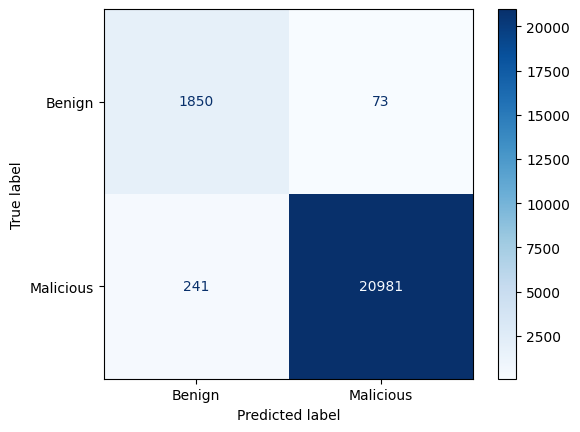

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)
labels = ['Benign', 'Malicious']

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [32]:
import joblib

joblib.dump(best_model, "lgbm_model.pkl")

['lgbm_model.pkl']

In [39]:
X_train

,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,icmp,tcp,udp
752107,-1.000000,NaN,NaN,1.0,40.0,0.0,0.0,False,False,True
86101,-1.000000,NaN,NaN,1.0,40.0,0.0,0.0,False,False,True
838790,2.998566,0.0,0.0,3.0,180.0,0.0,0.0,False,True,False
757800,-1.000000,NaN,NaN,1.0,60.0,0.0,0.0,False,True,False
449715,-1.000000,NaN,NaN,1.0,60.0,0.0,0.0,False,True,False
...,...,...,...,...,...,...,...,...,...,...
259178,2.998788,0.0,0.0,3.0,180.0,0.0,0.0,False,True,False
365838,2.998536,0.0,0.0,3.0,180.0,0.0,0.0,False,True,False
131932,-1.000000,NaN,NaN,1.0,40.0,0.0,0.0,False,False,True
671155,-1.000000,NaN,NaN,1.0,40.0,0.0,0.0,False,False,True


In [45]:
df[params + [label]].iloc[100].to_dict()

{'duration': 2.998559,
 'orig_bytes': 0.0,
 'resp_bytes': 0.0,
 'orig_pkts': 3.0,
 'orig_ip_bytes': 180.0,
 'resp_pkts': 0.0,
 'resp_ip_bytes': 0.0,
 'icmp': False,
 'tcp': True,
 'udp': False,
 'label_target': 1}

In [60]:
emulation_df = df[df['id.orig_h'] == '192.168.100.103'].sort_values(by='ts')

In [65]:
emulation_X = pd.concat([
    emulation_df[emulation_df[label] == 0].iloc[:30],
    emulation_df[emulation_df[label] == 1].iloc[:30],
])[params + [label]]

In [66]:
emulation_X

,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,icmp,tcp,udp,label_target
90,-1.000000,NaN,NaN,1.0,40.0,0.0,0.0,False,False,True,0
94,-1.000000,NaN,NaN,1.0,40.0,0.0,0.0,False,False,True,0
96,-1.000000,NaN,NaN,1.0,40.0,0.0,0.0,False,False,True,0
6,2.998804,0.0,0.0,3.0,180.0,0.0,0.0,False,True,False,0
7,-1.000000,NaN,NaN,1.0,60.0,0.0,0.0,False,True,False,0
99,-1.000000,NaN,NaN,1.0,40.0,0.0,0.0,False,False,True,0
101,-1.000000,NaN,NaN,1.0,40.0,0.0,0.0,False,False,True,0
103,-1.000000,NaN,NaN,1.0,40.0,0.0,0.0,False,False,True,0
106,-1.000000,NaN,NaN,1.0,40.0,0.0,0.0,False,False,True,0
109,-1.000000,NaN,NaN,1.0,40.0,0.0,0.0,False,False,True,0


In [59]:
emulation_X.to_csv('emulated_data.csv', index=False)

## DNN

In [26]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [27]:
data = pd.read_csv("./CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv", sep="|")
data['ts'] = pd.to_datetime(data['ts'], unit='s')

data.replace("-", np.nan, inplace=True)
data.fillna(0, inplace=True)
data = data.sort_values(by='ts')

features = [
    "id.orig_p", "id.resp_p", "proto", "duration", "orig_bytes", "resp_bytes",
    "conn_state", "orig_pkts", "orig_ip_bytes", "resp_pkts", "resp_ip_bytes"
]
target = "label"

encoder_proto = LabelEncoder()
data["proto"] = encoder_proto.fit_transform(data["proto"])

encoder_conn = LabelEncoder()
data["conn_state"] = encoder_conn.fit_transform(data["conn_state"])

encoder_label = LabelEncoder()
data["label"] = encoder_label.fit_transform(data["label"])

scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

X = data[features].values
y = data[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

<ipython-input-27-49e2c0060e57>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace("-", np.nan, inplace=True)


In [28]:
class FullyConnectedModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(FullyConnectedModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
input_dim = X_train.shape[1]
num_classes = len(torch.unique(y_train_tensor))
model = FullyConnectedModel(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

Epoch 1/5, Loss: 0.0401
Epoch 2/5, Loss: 0.0280
Epoch 3/5, Loss: 0.0237
Epoch 4/5, Loss: 0.0219
Epoch 5/5, Loss: 0.0214


In [29]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9958
